In [1]:
import logging
from importlib import reload

import himalaya.scoring
import matplotlib.pyplot as plt
import numpy as np
from himalaya.backend import set_backend
from matplotlib import axes

from simulation import generate_dataset

set_backend("cupy", on_error="warn")

# disable warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [3]:
def generic_errorbar_plot(means, variances, labels, horizontal_positions, title, suptitle, ylabel, xlabel,
                          n_samples_train, n_samples_test, ax: axes.Axes = None, fig=None):
    """Generic plot function for shared parameters between vp_errorbar and rm_errorbar."""

    if ax is None or fig is None:
        fig, ax = plt.subplots()

    yerr = [np.sqrt(var) / np.sqrt(n_samples_test) for var in variances]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

    # Create bar plot
    bars = ax.bar(range(len(means)), means, color=colors[:len(means)], yerr=yerr, capsize=5, ecolor="black")
    ax.bar_label(bars, fmt='{:,.2f}', label_type='center')
    ax.set_xticks(range(len(means)), labels=labels)

    # Function to plot horizontal lines
    def plot_horizontal_line(start, end, y_value, label, color):
        ax.plot([start, end], [y_value, y_value], linestyle='--', label=label, color=color)

    # Plot horizontal lines
    for i, (y_value, label, start, end) in enumerate(horizontal_positions):
        plot_horizontal_line(start, end, y_value, label, colors[i % len(colors)])

    ax.legend()

    ylims = ax.get_ylim()
    ax.set_ylim(ylims[0], 1.01)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    fig.suptitle(suptitle)
    ax.set_title(title)
    return ax, fig

In [4]:
feature_space_dimensions = [
    100,  # shared
    100,  # unique 0
    100,  # unique 1
]
scalars = [
    1 / 3, 1 / 3, 1 / 3
]
n_targets = 1000
n_samples_train = 10000
n_samples_test = 1000
noise_scalar = 0.1

cv = 20
alphas = np.logspace(-4, 4, 10)

In [5]:
(Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(feature_space_dimensions, scalars, n_targets, n_samples_train,
                                                        n_samples_test, noise_scalar)

# Variance Partitioning

In [10]:
def vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, scalars,
                n_targets, n_samples_train, n_samples_test, noise_scalar, ax: axes.Axes = None, fig=None):
    # Precompute means and variances
    scores = [score_0, score_1, joint_score, shared, x0_unique, x1_unique]
    means = [s.mean() for s in scores]
    variances = [s.var() for s in scores]

    bar_names = [r"$X_0$", r"$X_1$", r"$X_0 \cup X_1$", r"$X_0 \cap X_1$", r"$X_0 \setminus X_1$",
                 r"$X_1 \setminus X_0$"]

    # Horizontal line positions
    horizontal_positions = [
        (scalars[0] + scalars[1], r"$a_S + a_{U_0}$", -0.5, 0.5),
        (scalars[0] + scalars[2], r"$a_S + a_{U_1}$", 0.5, 1.5),
        (sum(scalars), r"$a_S + a_{U_0} + a_{U_1}$", 1.5, 2.5),
        (scalars[0], r"$a_S$", 2.5, 3.5),
        (scalars[1], r"$a_{U_0}$", 3.5, 4.5),
        (scalars[2], r"$a_{U_1}$", 4.5, 5.5)
    ]

    # Call the generic function
    generic_errorbar_plot(
        means=means,
        variances=variances,
        labels=bar_names,
        horizontal_positions=horizontal_positions,
        title=fr"$a_S$: {scalars[0]:.2f}, $a_{{U_0}}$: {scalars[1]:.2f}, $a_{{U_1}}$: {scalars[2]:.2f}, $|S|$: {feature_space_dimensions[0]}, $|U_0|$: {feature_space_dimensions[1]}, $|U_1|$: {feature_space_dimensions[2]}, $a_E$: {noise_scalar}",
        suptitle="Variance partitioning",
        ylabel=r"Average Variance Explained ($r^2$)",
        xlabel="Feature space",
        n_samples_test=n_samples_test,
        n_samples_train=n_samples_train,
        ax=ax,
        fig=fig
    )

In [11]:
from variance_partitioning import variance_partitioning

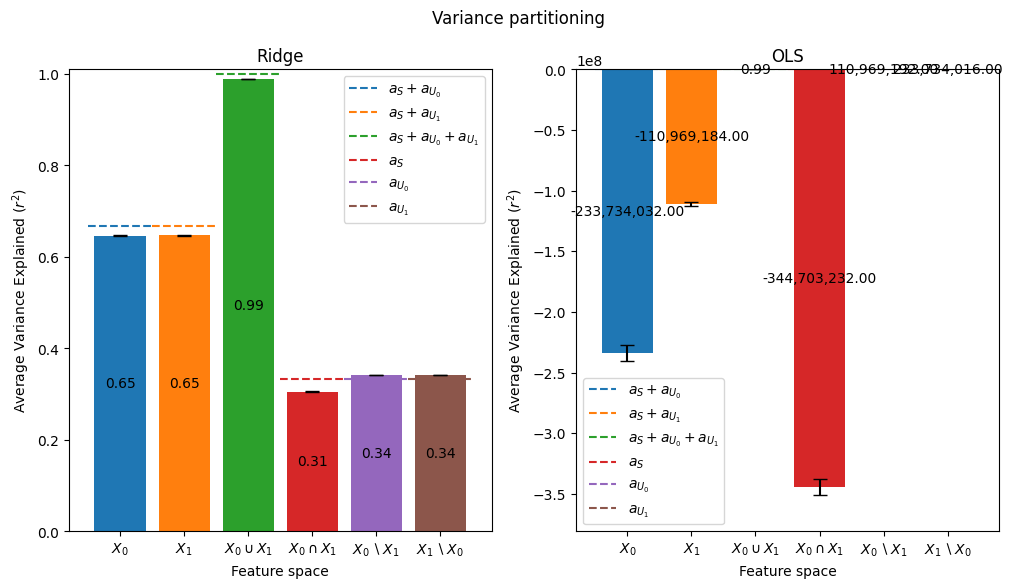

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
(score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test,
                                                                                      Y_train,
                                                                                      Y_test, cv=cv,
                                                                                      alphas=alphas,
                                                                                      logger=logger)
vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, scalars, n_targets,
            n_samples_train, n_samples_test, noise_scalar, ax=axs[0], fig=fig)
axs[0].set_title("Ridge")
(score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test,
                                                                                      Y_train,
                                                                                      Y_test, cv=cv,
                                                                                      alphas=alphas,
                                                                                      logger=logger, use_ols=True)
vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, scalars, n_targets,
            n_samples_train, n_samples_test, noise_scalar, ax=axs[1], fig=fig)
axs[1].set_title("OLS")

plt.show()

# Residual Method

In [6]:
from residual import residual_method

In [7]:
def rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1,
                feature_space_dimensions, scalars,
                n_targets, n_samples_train, n_samples_test, noise_scalar, ax: axes.Axes = None, fig=None):
    if ax is None or fig is None:
        fig, ax = plt.subplots()

    # Precompute means and variances
    scores = [full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1]
    means = [s.mean() for s in scores]
    variances = [s.var() for s in scores]

    bar_names = [r"$X_0$", r"$X_1$", r"$f(X_1) \approx X_0$", r"$g(X_0) \approx X_1$", r"$X_0 \setminus X_1$",
                 r"$X_1 \setminus X_0$"]

    horizontal_positions = [
        (scalars[0] + scalars[1], r"$a_S + a_{U_0}$", -0.5, 0.5),
        (scalars[0] + scalars[2], r"$a_S + a_{U_1}$", 0.5, 1.5),
        (feature_space_dimensions[0] / (feature_space_dimensions[0] + feature_space_dimensions[1]),
         r"$\frac{|S|}{|U_0|+|S|}$", 1.5, 2.5),
        (feature_space_dimensions[0] / (feature_space_dimensions[0] + feature_space_dimensions[2]),
         r"$\frac{|S|}{|U_1|+|S|}$", 2.5, 3.5),
        (scalars[1], r"$a_{U_0}$", 3.5, 4.5),
        (scalars[2], r"$a_{U_1}$", 4.5, 5.5)
    ]

    # Call the generic_errorbar function with the required data and parameters
    generic_errorbar_plot(
        means=means,
        variances=variances,
        labels=bar_names,
        horizontal_positions=horizontal_positions,
        title=fr"{n_targets} targets, $a_S$: {scalars[0]:.2f}, $|S|$: {feature_space_dimensions[0]}, $a_{{U_0}}$: {scalars[1]:.2f}, $|U_0|$: {feature_space_dimensions[1]}, $a_{{U_1}}$: {scalars[2]:.2f}, $|U_1|$: {feature_space_dimensions[2]}, $a_E$: {noise_scalar}",
        suptitle="Residual Method",
        ylabel=r"Average Variance Explained ($r^2$)",
        xlabel="Feature space/Model",
        n_samples_test=n_samples_test,
        n_samples_train=n_samples_train,
        ax=ax,
        fig=fig
    )

12:16:11 DEBUG:[ 100.     1000.0001  100.      100.      100.     1000.0001  100.
  100.     1000.0001  100.     1000.0001  100.     1000.0001  100.
 1000.0001  100.      100.     1000.0001  100.      100.      100.
  100.      100.      100.      100.      100.      100.      100.
  100.      100.      100.      100.      100.      100.     1000.0001
  100.     1000.0001  100.      100.      100.      100.      100.
  100.      100.      100.      100.      100.      100.      100.
 1000.0001  100.      100.      100.      100.      100.      100.
  100.      100.      100.      100.      100.      100.      100.
  100.      100.      100.      100.      100.      100.     1000.0001
  100.      100.      100.      100.      100.      100.      100.
  100.      100.      100.      100.      100.      100.      100.
  100.     1000.0001  100.      100.      100.      100.      100.
  100.      100.      100.      100.      100.      100.      100.
  100.      100.      100.     1000.000

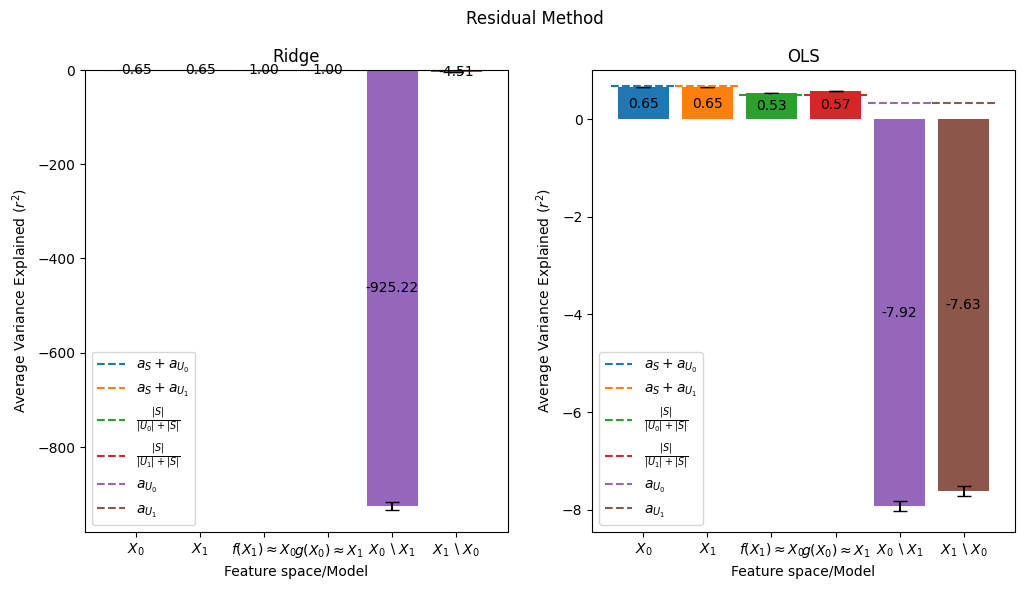

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1 = residual_method(
    Xs_train, Xs_test, Y_train, Y_test, return_full_variance=True, cv=cv,
    score_func=himalaya.scoring.r2_score
)
rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1,
            feature_space_dimensions, scalars, n_targets, n_samples_train, n_samples_test, noise_scalar, ax=axs[0],
            fig=fig)
axs[0].set_title("Ridge")
full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1 = residual_method(
    Xs_train, Xs_test, Y_train, Y_test, use_ols=True, return_full_variance=True, cv=cv,
    score_func=himalaya.scoring.r2_score
)
rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1,
            feature_space_dimensions, scalars, n_targets, n_samples_train, n_samples_test, noise_scalar, ax=axs[1],
            fig=fig)
axs[1].set_title("OLS")

plt.show()

# Dimensions

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharey='row')

for i, shared_dimension in enumerate([10, 100, 1000]):
    dimensions = feature_space_dimensions.copy()
    dimensions[0] = shared_dimension

    _n_samples_train = 2 * sum(dimensions)

    (Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(dimensions, scalars, n_targets,
                                                            _n_samples_train,
                                                            n_samples_test, noise_scalar)
    (score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test,
                                                                                          Y_train,
                                                                                          Y_test, cv=cv)
    vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, dimensions, scalars, n_targets,
                _n_samples_train, n_samples_test, noise_scalar, ax=axs[i, 0], fig=fig)
    axs[i, 0].set_title(f"Variance Partitioning (Shared Dim: {shared_dimension})")

    (full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0,
     residual_scores_1) = residual_method(
        Xs_train, Xs_test, Y_train, Y_test, use_ols=True, return_full_variance=True, cv=cv)

    rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1,
                dimensions, scalars, n_targets, _n_samples_train, n_samples_test, noise_scalar, ax=axs[i, 1], fig=fig)
    axs[i, 1].set_title(f"Residual Method (Shared Dim: {shared_dimension})")

plt.tight_layout()
plt.show()

# Scalars

In [ ]:
# Updated code to put each plot into the subplot axes, with scalars along the rows and vp and rm in the columns
n_scalars = 5
fig, axs = plt.subplots(n_scalars, 2, figsize=(12, n_scalars * 4), sharey='row')  # Adjust figure size dynamically

for i, shared_scalar in enumerate(np.linspace(0, 1, n_scalars)):
    _scalars = [shared_scalar, (1 - shared_scalar) / 2, (1 - shared_scalar) / 2]
    (Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(feature_space_dimensions, _scalars,
                                                            n_targets,
                                                            n_samples_train, n_samples_test,
                                                            noise_scalar)
    (score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test,
                                                                                          Y_train,
                                                                                          Y_test, cv=cv,
                                                                                          score_func=himalaya.scoring.r2_score)
    # Variance Partitioning subplot
    vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, _scalars,
                n_targets, n_samples_train, n_samples_test, noise_scalar, ax=axs[i, 0], fig=fig)
    axs[i, 0].set_title(f"Variance Partitioning (Shared scalar: {shared_scalar:.2f})")

    # Residual Method subplot
    full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1 = residual_method(
        Xs_train, Xs_test, Y_train, Y_test, use_ols=True, return_full_variance=True, cv=cv,
        score_func=himalaya.scoring.r2_score)

    rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1,
                feature_space_dimensions, _scalars, n_targets, n_samples_train, n_samples_test, noise_scalar,
                ax=axs[i, 1], fig=fig)
    axs[i, 1].set_title(f"Residual Method (Shared scalar: {shared_scalar:.2f})")

plt.tight_layout()  # To avoid overlap of subplots
plt.show()